# The 24 Metabolite Panel

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 04APR2020


In [10]:
import yellowbrick 
print (yellowbrick.__version__)

1.3.post1


## Import Libraries

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
from scipy import stats
import statsmodels as sms
from statsmodels.stats import multitest
import seaborn as sns; sns.set(style='white')

#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

from sklearn import decomposition

## Import Data

In [2]:
RCCdataframe = pd.read_excel('data/RCCdataframe.xlsx')

#RCCdataframe = pd.read_excel('RCCdataframe.xlsx')
# Remove samples with inconclusive staging information.
RCCdataframe = RCCdataframe[pd.notnull(RCCdataframe['Grouped Stage'])]

In [3]:
# non-metabolites (non-features) elements in RCC dataframe
non_metabolites = ['Groups', 'Collection', 'Sample ID', 'Metastatic', 
     'SubTypes','Nuclear Grade', 'Grade', 'Tstage', 
     'Tstage Group', 'Nstage', 'Mstage', 
     'Stage', 'Grouped Stage','Tumor Width','Gender', 
     'Race', 'BMI', 'Smoker', 'Age', 'Patient ID' ]

In [4]:
# Define two dataframes, Early RCC cancer and Late RCC cancer, and drop
# non-metabolites features from these dataframes.

Early = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Early')].drop(non_metabolites,
                                                                      axis=1)
Late = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Late')].drop(non_metabolites,
                                                                      axis=1)

In [5]:
# df_features contains the features alone. 
df_features = RCCdataframe.drop(non_metabolites, axis=1)

In [6]:
df_features.shape

(70, 7146)

In [7]:
MS_features = df_features.iloc[:, 1:7098].columns
NMR_features = df_features.iloc[:, 7098:].columns

## Quantitation and Significance Tests

### T-test Function

In [8]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

### LC-MS Metabolic Features

In [9]:
ttest_result = Ttest(MS_features, Early, Late, alpha=0.05, var=True)
MSstat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]

In [10]:
MSstat_sig.head(5)

,Metabolite,T-test p-value,FDR p-value,Reject H0
7000,7001,0.000160,0.189336,False
6395,6396,0.000155,0.189336,False
6336,6337,0.000126,0.189336,False
5407,5408,0.000114,0.189336,False
5064,5065,0.000094,0.189336,False


### NMR Metabolic Features

In [11]:
ttest_result = Ttest(NMR_features, Early, Late, alpha=0.05, var=True)
NMRstat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]

In [12]:
NMRstat_sig.head(20)

,Metabolite,T-test p-value,FDR p-value,Reject H0
13,citrate,0.002546,0.122210,False
8,acetone,0.028642,0.305652,False
22,glycine,0.031839,0.305652,False
12,pyruvate,0.028291,0.305652,False
18,choline,0.026118,0.305652,False


### 24-Metabolite Panel

Metabolite Identity

In [13]:
final_features = {2745, 5362, 6681, 3766,
                  1372, 1904, 2122, 2317, 
                  2465, 3163, 4116, 5045, 
                  5420, 5437, 5713, 
                  5737, 5985, 6687, 6694,
                  'citrate', 'glycine', 'choline',
                  'acetone', 'pyruvate'}

MLfeatures = RCCdataframe[list(final_features)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

rename

In [14]:
group_loc = RCCdataframe.columns.get_loc("Grouped Stage") #location of grouped stage.
biomarker =  RCCdataframe.iloc[:, group_loc].to_frame().join(MLfeatures)

biomarker.rename(columns={2745 : 'Cytosine dimer', 3163 : '279.1m/z', 3766 : 'Apo-', 
                          5362 : 'Dihydrouridine',
                          6681 : 'Hydroxyprolyl-Asparagine', 1372 : '4-Guanidinobutanoic acid',
                          1904 : '7-Aminomethyl-7-carbaguanine', 2122 : 'Nalpha-Nalpha-Dimethyl-L-histidine',
                          2317 : 'Diethy-2-methyl-3-oxosuccinate', 2465 : '3-Hydroxyanthranilic acid',
                          4116 : '119.06m/z', 5045: '218.01m/z', 5420 : "205.05m/z",
                          5437 : '123.01m/z', 5713 : '305.01m/z', 5737 : "Lys-gly",
                          5985 : 'Succinic anhydride', 6687 : '369.05m/z', 6694 : '409.98m/z'

}, inplace=True)

MS features sig. statistics

In [15]:
MSstat_sig[MSstat_sig.Metabolite.isin(list(final_features))]

,Metabolite,T-test p-value,FDR p-value,Reject H0
6686,6687,0.000149,0.189336,False
3765,3766,0.000545,0.243436,False
3162,3163,0.000318,0.243436,False
5436,5437,0.000454,0.243436,False
5736,5737,0.000707,0.278777,False
2121,2122,0.000802,0.279565,False
4115,4116,0.001083,0.301019,False
2744,2745,0.001406,0.321986,False
1903,1904,0.001400,0.321986,False
5044,5045,0.002350,0.417155,False


NMR features sig. statistics

In [16]:
NMRstat_sig[NMRstat_sig.Metabolite.isin(list(final_features))]

,Metabolite,T-test p-value,FDR p-value,Reject H0
13,citrate,0.002546,0.122210,False
8,acetone,0.028642,0.305652,False
22,glycine,0.031839,0.305652,False
12,pyruvate,0.028291,0.305652,False
18,choline,0.026118,0.305652,False


Boxplot

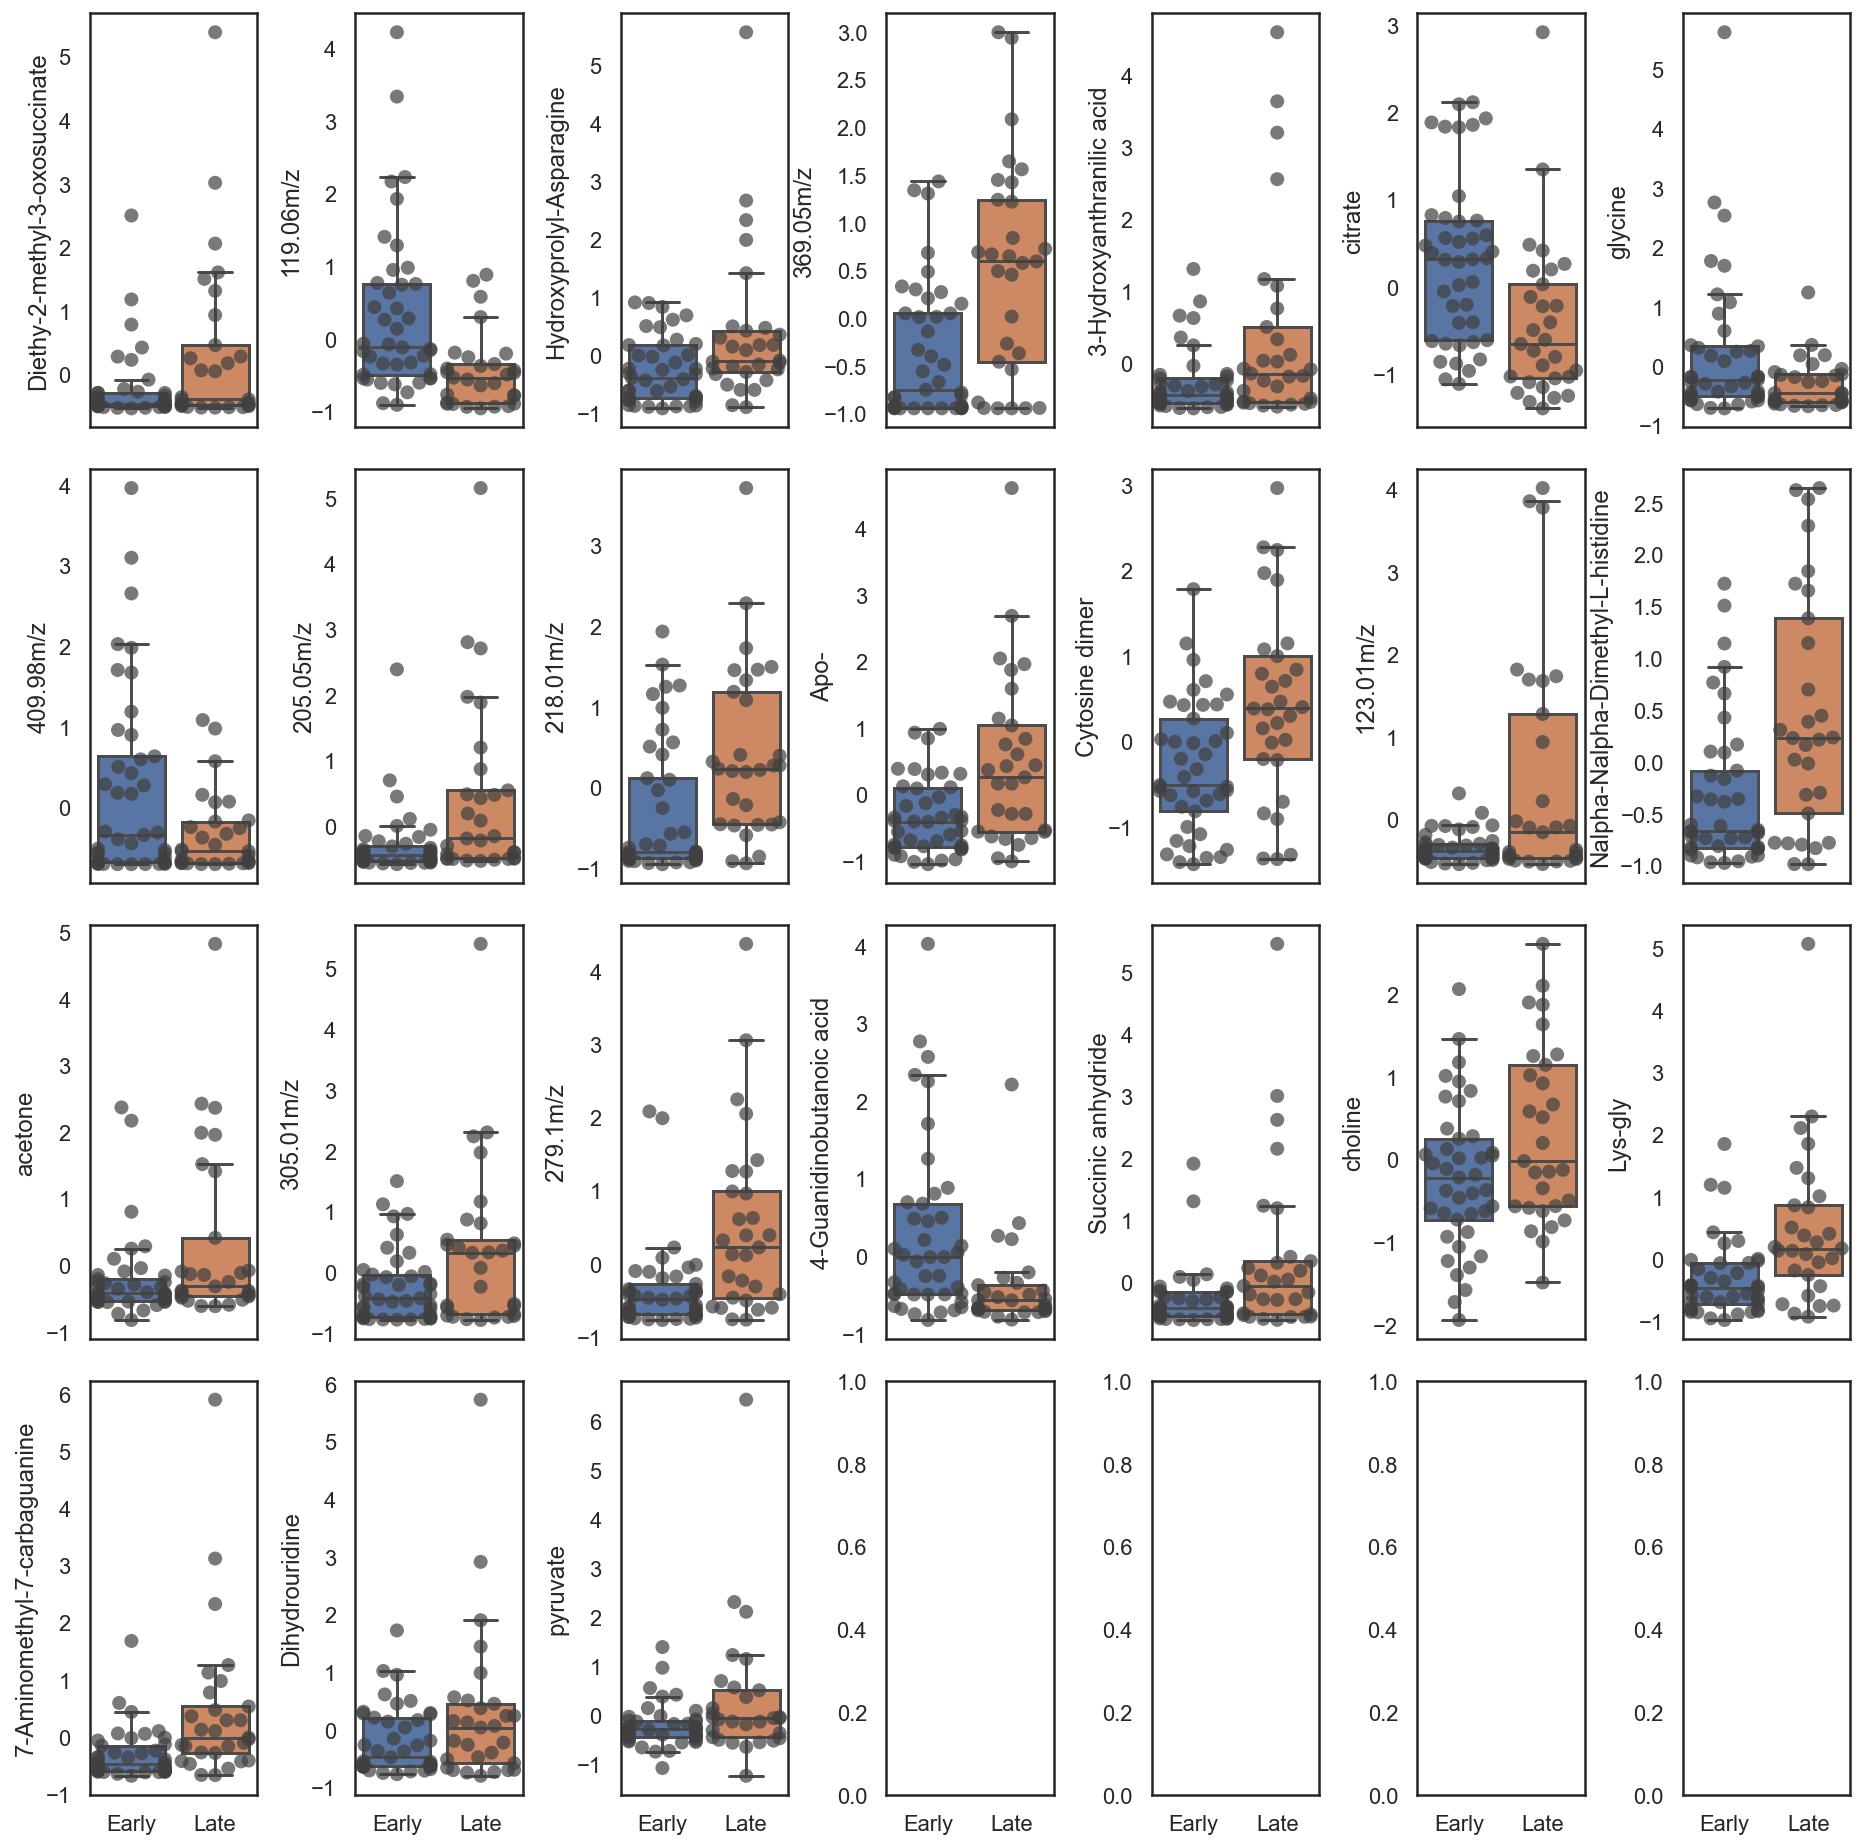

In [17]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=7, sharex=True, figsize=(13, 13))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 7), idx % 7]
    sns.boxplot(x='Grouped Stage', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Grouped Stage', y=feat, data=biomarker, ax=ax, capsize=.06)
    sns.swarmplot(x='Grouped Stage', y=feat, data=biomarker, 
                  ax=ax, s=7, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)

## PCA

### PCA functions

In [18]:
def PCA_Python(X, y, Group1, Group2, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    Group1: String. Name of first group.
    Group2: String. Name of second group.
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label=Group1);
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label=Group2);
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

In [19]:
def PCA_Python3D(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=3)
    if scaled == True:
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component.
    #plt.title('PCA Score plot for Molecular Descriptors');
    ax=plt.figure(figsize=(16,10)).gca(projection='3d')
    ax.scatter(
        xs=X_pca[:,0],
        ys=X_pca[:,1],
        zs=X_pca[:,2],
        s=50, c=y,
        cmap="bwr"
    )
    
    return ax, Var

### Early vs Advanced RCC

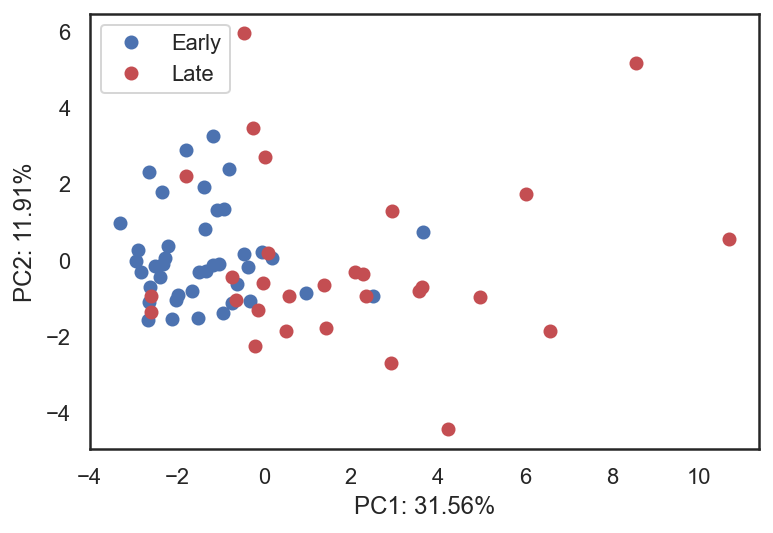

In [20]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Grouped Stage'].map({'Early': 0, 'Late': 1}) 
PCA_Python(stagedata, classes, 'Early', 'Late', scaled=True);

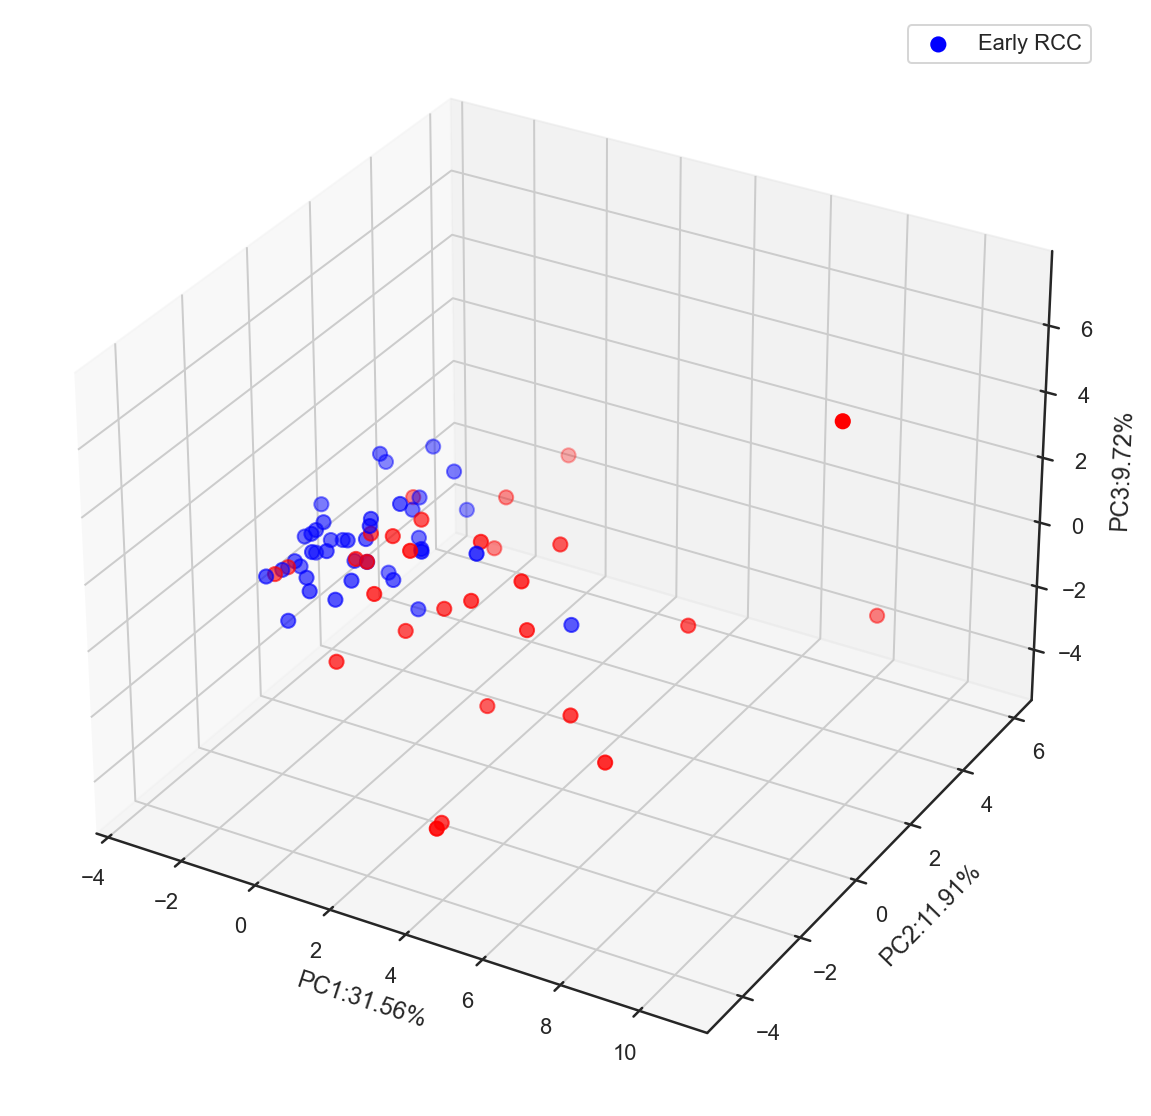

In [21]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
ax.legend(["Early RCC", "Late RCC"])
#ax.legend(['Early RCC'])
plt.show()

## Hierarchial Clustering

In [22]:
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling
# index of grouped stage in RCCdataframe
stage_loc = RCCdataframe.columns.get_loc("Grouped Stage") 
# marker is the dataframe for our boxplot
stagedata = RCCdataframe.iloc[:, stage_loc].to_frame().join(MLfeatures).dropna()

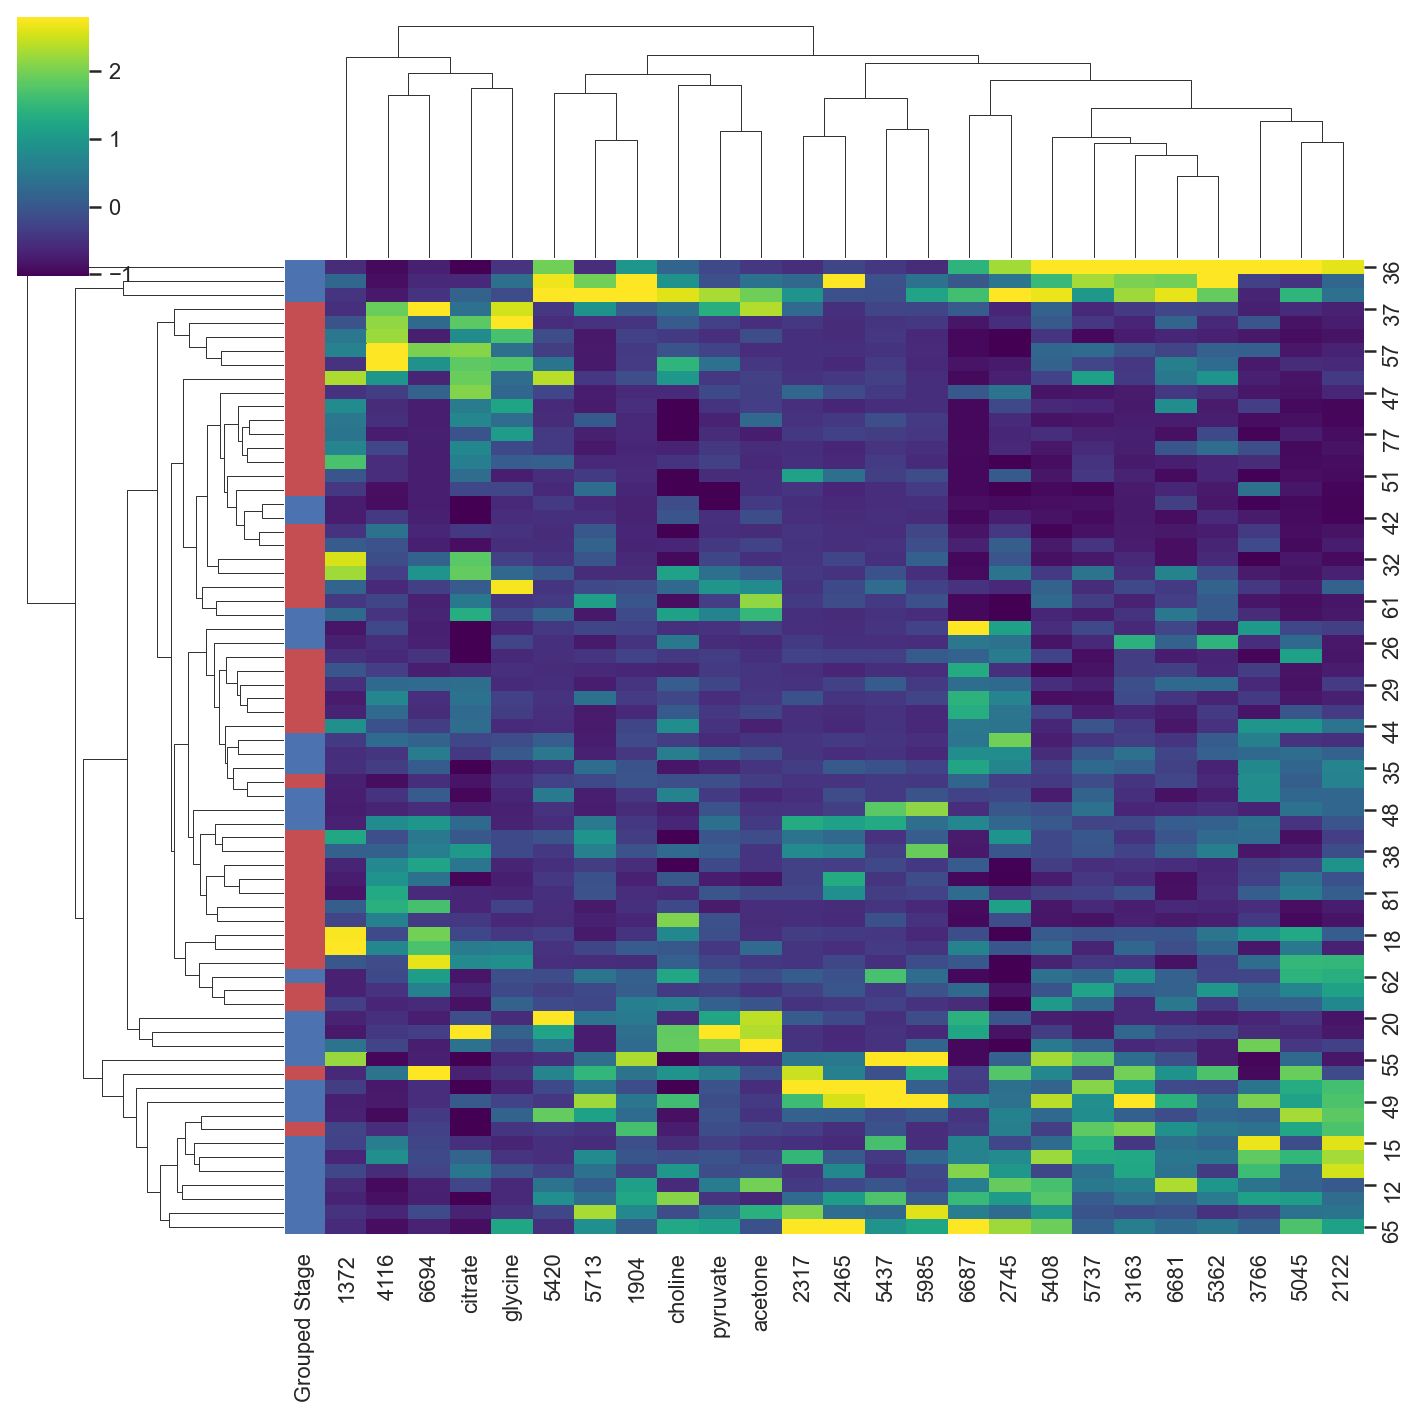

In [23]:
groups_two = stagedata.pop('Grouped Stage')
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(stagedata, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=True, 
                   row_colors=row_colors, robust=True);
# define biomarker dataframe again because of the .pop method
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling
stage_loc = RCCdataframe.columns.get_loc("Grouped Stage") 
stagedata = RCCdataframe.iloc[:, stage_loc].to_frame().join(MLfeatures).dropna()

## Patient Cohort Characteristics

### Collection Method

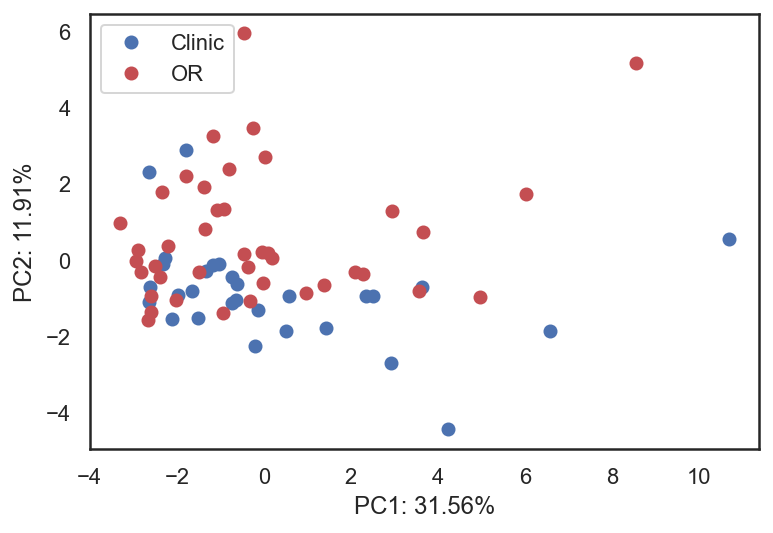

In [24]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Collection'].map({'Clinic': 0, 'OR': 1}) 
PCA_Python(stagedata, classes, 'Clinic', 'OR', scaled=True);

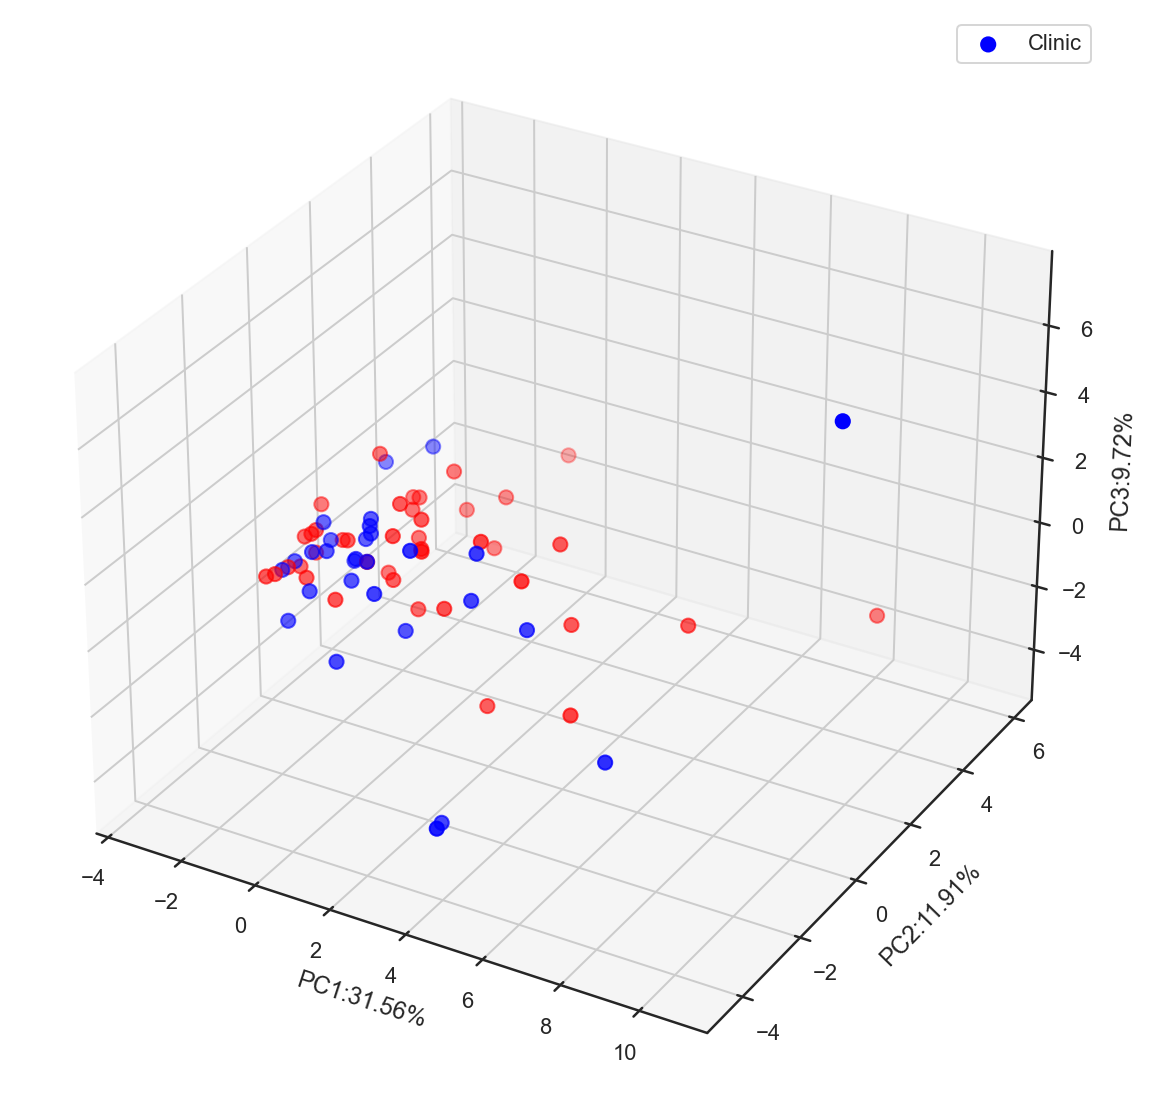

In [25]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
#ax.legend(["Early RCC", "Late RCC"])
ax.legend(["Clinic", "OR"])
#ax.legend((0, 1), ("Clinic", "OR"))
#plt.savefig('PCA_collection_method.svg')
plt.show()

### Gender

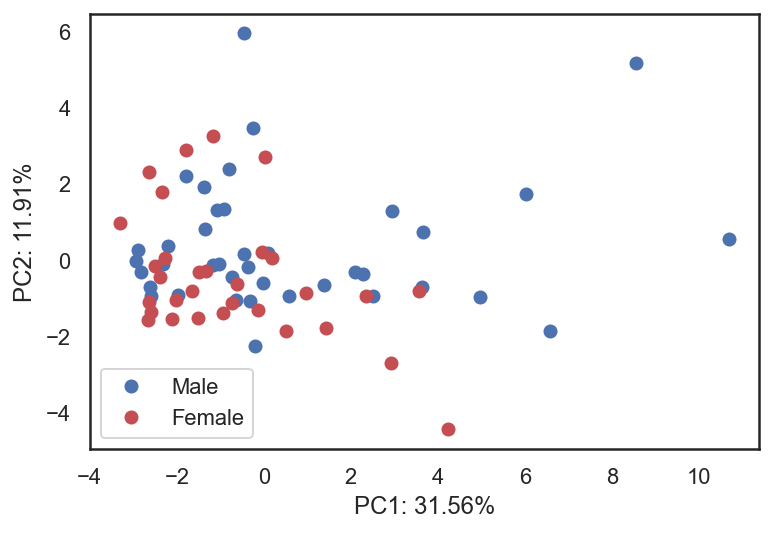

In [26]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Gender'].map({'Male': 0, 'Female': 1}) 
PCA_Python(stagedata, classes, 'Male', 'Female', scaled=True);

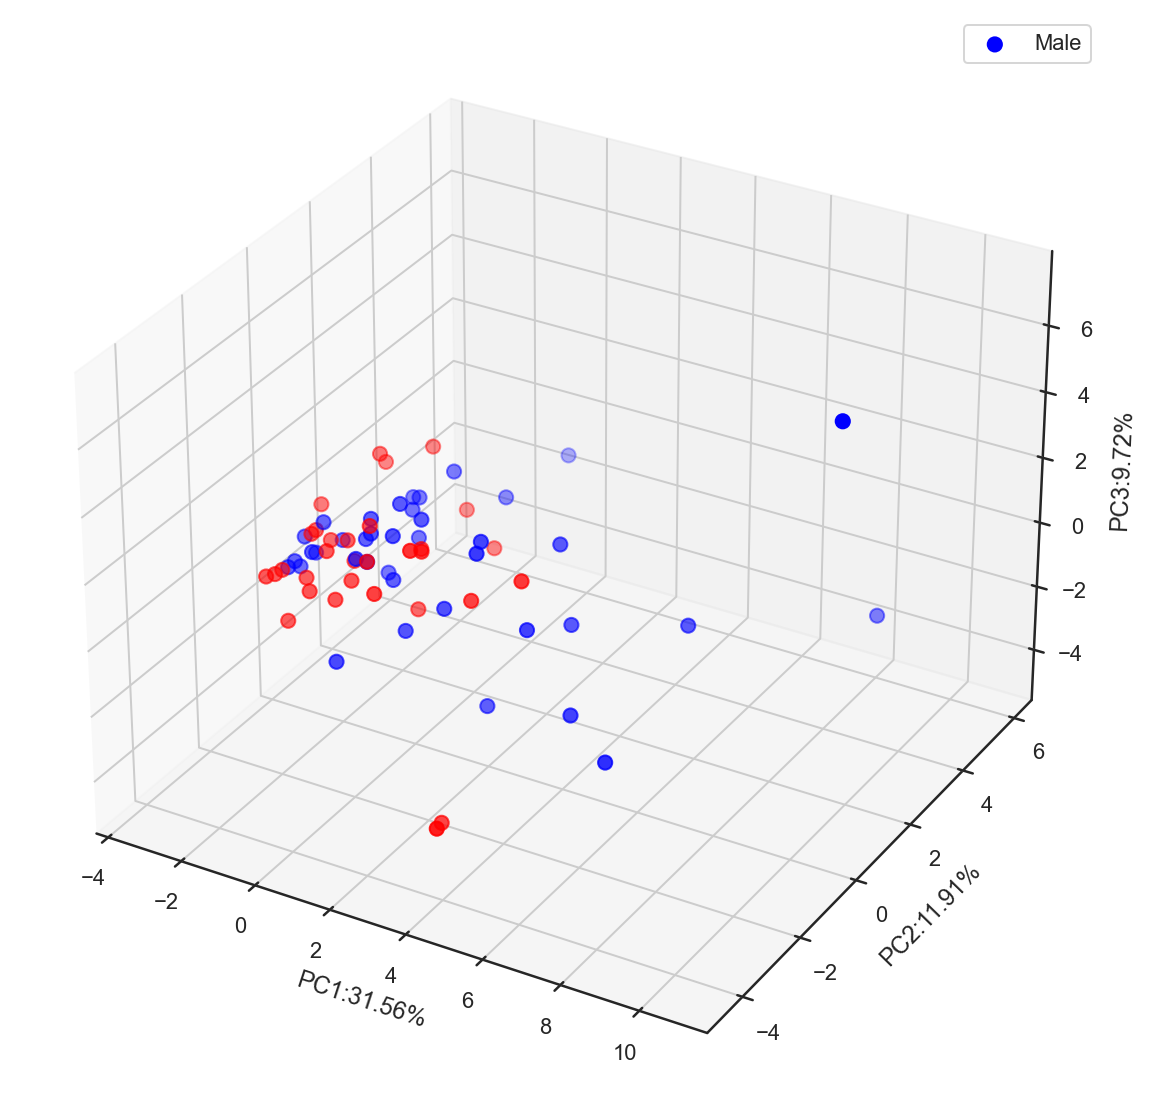

In [27]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
ax.legend(['Male', 'Female'])
#ax.legend((0, 1), ("Early RCC", "Late RCC"))
#plt.savefig('PCA_Gender.svg')
plt.show()

In [28]:
# Proportion of genders. 
dEarly = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Early')]
dLate = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Late')]
print(dEarly['Gender'].value_counts())
print(dEarly['Gender'].value_counts(normalize=True)*100)
print(dLate['Gender'].value_counts())
print(dLate['Gender'].value_counts(normalize=True)*100)

Female    22
Male      19
Name: Gender, dtype: int64
Female    53.658537
Male      46.341463
Name: Gender, dtype: float64
Male      20
Female     9
Name: Gender, dtype: int64
Male      68.965517
Female    31.034483
Name: Gender, dtype: float64


### Smoker

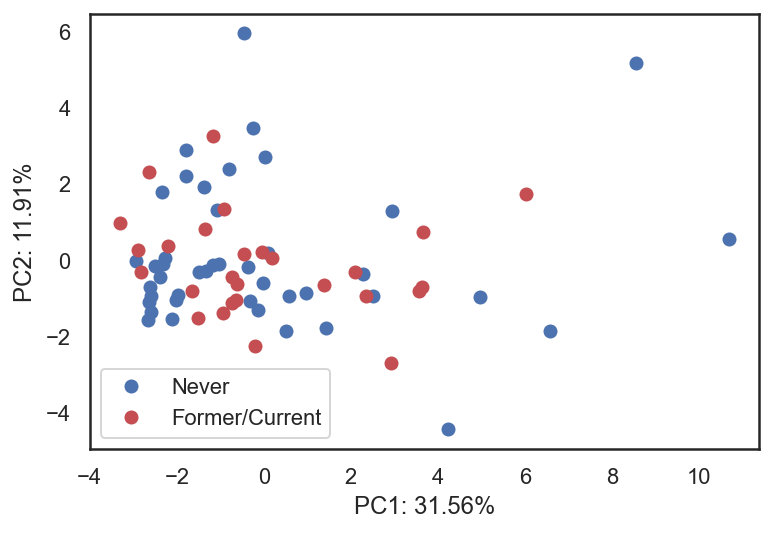

In [29]:
stagedata = RCCdataframe[MLfeatures.columns]
stagedata =(stagedata - stagedata.mean(axis=0))/stagedata.std(axis=0) #autoscaling
classes = RCCdataframe['Smoker'].map({'Never': 0, 'Former': 1, 'Current': 1}) 
PCA_Python(stagedata, classes, 'Never', 'Former/Current', scaled=True);

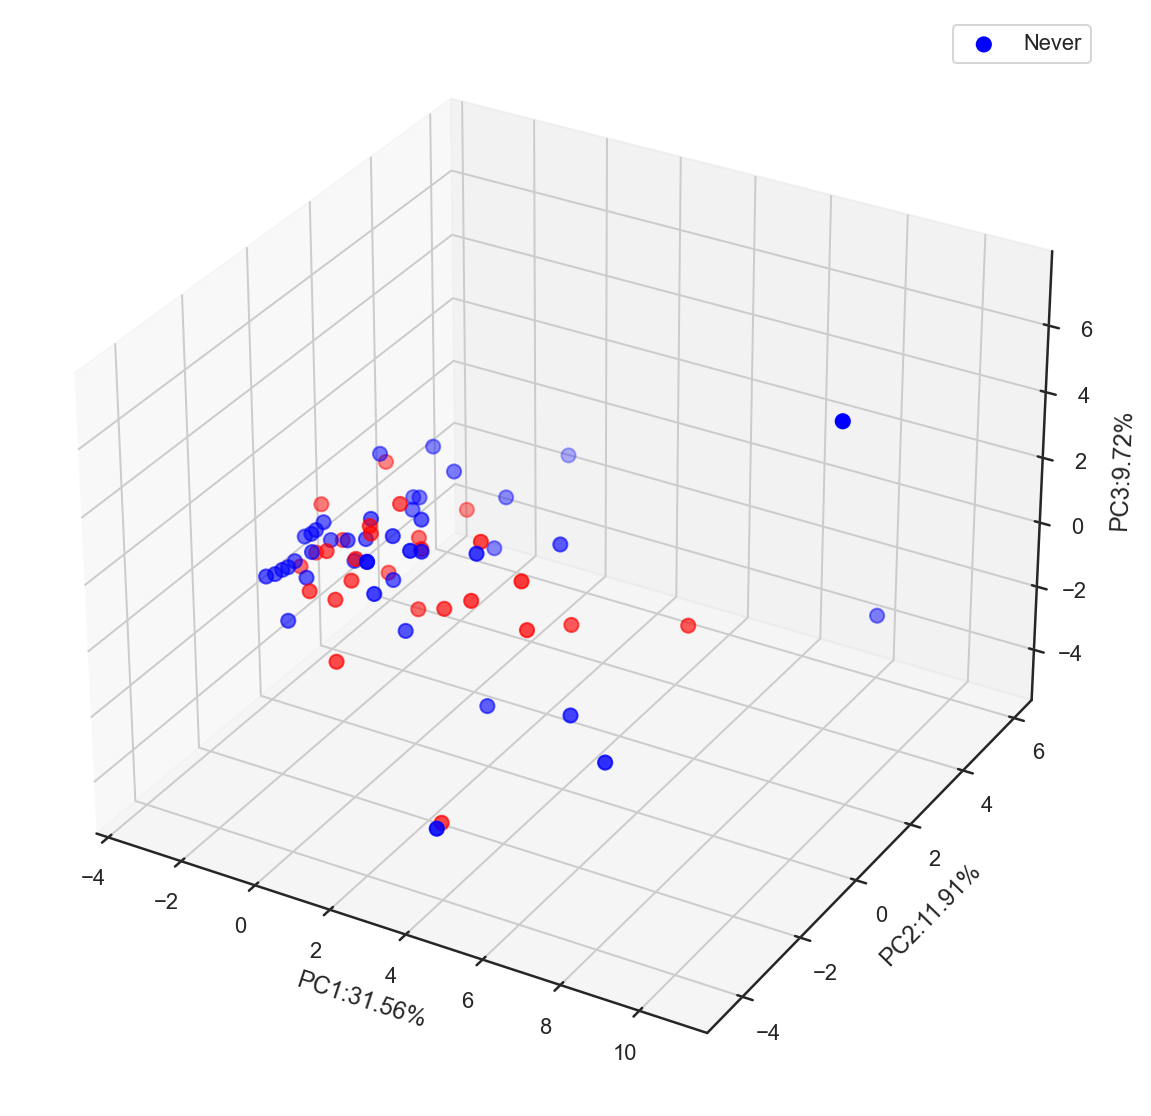

In [30]:
(ax, pcaVa) = PCA_Python3D(stagedata, list(classes), scaled=True)


ax.set_xlabel('PC1:'+str(round(pcaVa[0]*100, 2)) + "%")
ax.set_ylabel('PC2:'+str(round(pcaVa[1]*100, 2)) + "%")
ax.set_zlabel('PC3:'+str(round(pcaVa[2]*100, 2)) + "%")
ax.legend(['Never', 'Former/Current'])
#ax.legend((0, 1), ('Never', 'Former/Current'))
#plt.savefig('PCA_Smoker.svg')
plt.show()

In [32]:
#Proportion of smokers 

# Merge former and current smokers 
dEarly['Smoker'].replace({'Current': 'Former/Current', 'Former': 'Former/Current'}, 
                        inplace=True);
dLate['Smoker'].replace({'Current': 'Former/Current', 'Former': 'Former/Current'}, 
                        inplace=True);
print(dEarly['Smoker'].value_counts())
print(dEarly['Smoker'].value_counts(normalize=True)*100)
print(dLate['Smoker'].value_counts())
print(dLate['Smoker'].value_counts(normalize=True)*100)

Never             24
Former/Current    17
Name: Smoker, dtype: int64
Never             58.536585
Former/Current    41.463415
Name: Smoker, dtype: float64
Never             19
Former/Current    10
Name: Smoker, dtype: int64
Never             65.517241
Former/Current    34.482759
Name: Smoker, dtype: float64


### Race

In [33]:
print(dEarly['Race'].value_counts())
print(dEarly['Race'].value_counts(normalize=True)*100)
print(dLate['Race'].value_counts())
print(dLate['Race'].value_counts(normalize=True)*100)

White                             26
Black/AA                          14
American-Indian/Alaskan-Native     1
Name: Race, dtype: int64
White                             63.414634
Black/AA                          34.146341
American-Indian/Alaskan-Native     2.439024
Name: Race, dtype: float64
White          21
Black/AA        5
Unk/Missing     1
Asian           1
Mixed           1
Name: Race, dtype: int64
White          72.413793
Black/AA       17.241379
Unk/Missing     3.448276
Asian           3.448276
Mixed           3.448276
Name: Race, dtype: float64


### RCC SubTypes

In [34]:
print(dEarly['SubTypes'].value_counts())
print(dEarly['SubTypes'].value_counts(normalize=True)*100)
print(dLate['SubTypes'].value_counts())
print(dLate['SubTypes'].value_counts(normalize=True)*100)

Pure Clear Cell         23
Papillary                9
Clear Cell Papillary     4
Chromophobe              4
Unclassified             1
Name: SubTypes, dtype: int64
Pure Clear Cell         56.097561
Papillary               21.951220
Clear Cell Papillary     9.756098
Chromophobe              9.756098
Unclassified             2.439024
Name: SubTypes, dtype: float64
Pure Clear Cell    26
Unclassified        2
Papillary           1
Name: SubTypes, dtype: int64
Pure Clear Cell    89.655172
Unclassified        6.896552
Papillary           3.448276
Name: SubTypes, dtype: float64


### Nuclear Grades

In [35]:
print(dEarly['Nuclear Grade'].value_counts())
print(dEarly['Nuclear Grade'].value_counts(normalize=True)*100)
print(dLate['Nuclear Grade'].value_counts())
print(dLate['Nuclear Grade'].value_counts(normalize=True)*100)

2.0    21
3.0    17
4.0     3
Name: Nuclear Grade, dtype: int64
2.0    51.219512
3.0    41.463415
4.0     7.317073
Name: Nuclear Grade, dtype: float64
4.0    16
3.0    10
2.0     3
Name: Nuclear Grade, dtype: int64
4.0    55.172414
3.0    34.482759
2.0    10.344828
Name: Nuclear Grade, dtype: float64


### RCC Stages

In [36]:
print(dEarly['Stage'].value_counts())
print(dEarly['Stage'].value_counts(normalize=True)*100)
print(dLate['Stage'].value_counts())
print(dLate['Stage'].value_counts(normalize=True)*100)

1.0    33
2.0     8
Name: Stage, dtype: int64
1.0    80.487805
2.0    19.512195
Name: Stage, dtype: float64
3.0    15
4.0    14
Name: Stage, dtype: int64
3.0    51.724138
4.0    48.275862
Name: Stage, dtype: float64


### Age and BMI

In [37]:
def cohortQuant(cohortID, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the numerical cohort characteristics between two groups
    
    Inputs: 
    cohortID = A list of the numerical cohort characteristics
    dfControl = A pandas dataframe containing the control group cohort data
    dfTreat =  A pandas dataframe containing the treatment group cohort data
    alpha = alpha for statistical significant judgment, Default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    pvaluelist = []
    commentlist = []
    for conf in cohortID:
        statistic, pvalue = scipy.stats.ttest_ind(dfControl[conf], dfTreat[conf], 
                                              equal_var=var)
        pvaluelist.append(pvalue)
        if pvalue > alpha:
            comment = 'not significant'
        else:
            comment = 'significant'
        commentlist.append(comment)
    ConfTable = pd.DataFrame({'Confounder': cohortID, 
                              'T-test p-value': pvaluelist, 
                              'Comment': commentlist})
    return ConfTable

In [38]:
RCCdataframe['Grouped Stage'].value_counts()

Early    41
Late     29
Name: Grouped Stage, dtype: int64

In [39]:
confounderID = ['Age', 'BMI']
dEarly = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Early')]
dLate = RCCdataframe[(RCCdataframe['Grouped Stage'] == 'Late')]
cohortQuant(confounderID, dEarly, dLate, var=True)

,Confounder,T-test p-value,Comment
0,Age,0.630122,not significant
1,BMI,0.137707,not significant


In [40]:
print('Early RCC', dEarly.filter(['Age', 'BMI'], axis=1).describe())
print('Late RCC', dLate.filter(['Age', 'BMI'], axis=1).describe())

Early RCC              Age        BMI
count  41.000000  41.000000
mean   60.114634  29.948780
std    13.336258   5.224276
min    32.600000  21.100000
25%    53.000000  25.700000
50%    60.500000  30.000000
75%    69.200000  32.700000
max    83.700000  42.100000
Late RCC              Age        BMI
count  29.000000  29.000000
mean   61.675862  27.889655
std    13.251109   6.207274
min    30.200000  15.700000
25%    56.600000  23.900000
50%    62.300000  29.400000
75%    72.400000  31.400000
max    81.100000  38.500000


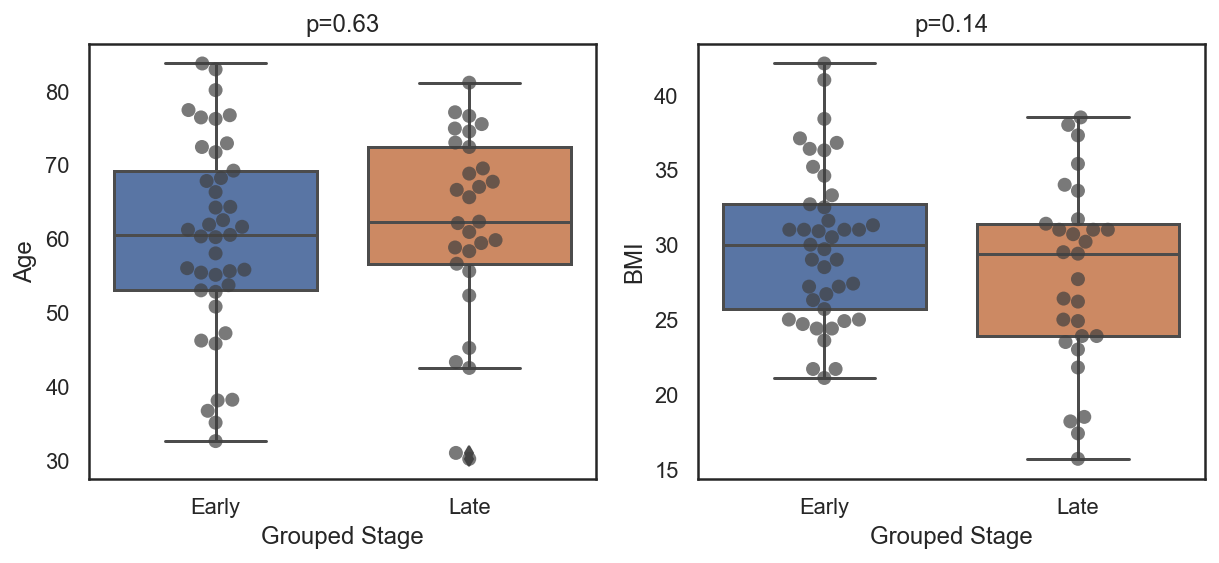

In [43]:
_, axes = plt.subplots(1, 2, sharey=False, figsize=(10, 4))

Age = sns.boxplot(x='Grouped Stage', y='Age', data=RCCdataframe, ax=axes[0]);
sns.swarmplot(x='Grouped Stage', y='Age', data=RCCdataframe, s =7, alpha=0.7, color=".25", ax=axes[0])
BMI = sns.boxplot(x='Grouped Stage', y='BMI', data=RCCdataframe, ax=axes[1]);
sns.swarmplot(x='Grouped Stage', y='BMI', data=RCCdataframe, s =7, alpha=0.7, color=".25", ax=axes[1])
Age.set_title('p=0.63',loc='center');
BMI.set_title('p=0.14',loc='center');
#plt.savefig('Age_BMI_.svg')